## Xfer with HyperParameter Optimization
When training neural networks, hyperparameters may have to be tuned to improve accuracy metrics. The purpose of this notebook is to demonstrate how to do *HyperParameter Optimization* (HPO) when repurposing neural networks in [Xfer](https://github.com/amzn/xfer). Here, we use [GPyOpt](https://github.com/SheffieldML/GPyOpt) to do HPO through Bayesian Optimization.

Note that depending on number of epochs, the target data set and transferability between source and target tasks, the default hyperparameter settings in Xfer could give desired results and HPO may not be required. If someone wants to try HPO, this notebook shows how to do it using GPyOpt.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.disable(logging.WARNING)

import gc
import glob
import os
import random
import time

import GPyOpt
import mxnet as mx
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import xfer

from matplotlib import pylab as plt
%matplotlib inline

#### Utility methods

In [2]:
def set_random_seeds():
    seed = 1234
    np.random.seed(seed)
    mx.random.seed(seed)
    random.seed(seed)
    GPyOpt.util.general.np.random.seed(seed) 
    GPyOpt.optimization.acquisition_optimizer.np.random.seed(seed)
    
def get_iterators(data_dir, train_size=0.3, validation_size=0.3, test_size=0.4, batch_size=1, 
                  label_name='softmax_label', data_name='data', random_state=1):
    """
    Method to create iterators from data stored in a folder with the following structure:
    /data_dir
        /class1
            class1_img1 ... class1_imgN
        /class2
            class2_img1 ... class2_imgN
        ...
        /classN
    """
    set_random_seeds()
    # Assert data_dir exists
    if not os.path.isdir(data_dir):
        raise ValueError('Directory not found: {}'.format(data_dir))
    # Get class names
    classes = [x.split('/')[-1] for x in glob.glob(data_dir+'/*')]
    classes.sort()
    fnames = []
    labels = []
    for c in classes:
            # Get all the image filenames and labels
            images = glob.glob(data_dir+'/'+c+'/*')
            images.sort()
            fnames += images
            labels += [c]*len(images)
    # Create label2id mapping
    id2label = dict(enumerate(set(labels)))
    label2id = dict((v,k) for k, v in id2label.items())

    # Split training(train+validation) and test data
    sss = StratifiedShuffleSplit(n_splits=2, test_size=None, train_size=train_size+validation_size, random_state=random_state)
    train_indices, test_indices = next(sss.split(labels, labels))
        
    # Training data (train+validation)
    train_validation_images = []
    train_validation_labels = []
    for idx in train_indices:
        train_validation_images.append([label2id[labels[idx]], fnames[idx]])
        train_validation_labels.append(label2id[labels[idx]])
        
    # Test data
    test_images = []
    test_labels = []
    for idx in test_indices:
        test_images.append([label2id[labels[idx]], fnames[idx]])
        test_labels.append(label2id[labels[idx]])
    
    # Separate validation set and train set
    train_percent = train_size / (train_size+validation_size)
    sss_1 = StratifiedShuffleSplit(n_splits=2, test_size=None, train_size=train_percent, random_state=random_state)
    train_indices, validation_indices = next(sss_1.split(train_validation_labels, train_validation_labels))
    train_images = []
    train_labels = []
    for idx in train_indices:
        train_images.append(train_validation_images[idx])
        train_labels.append(train_validation_labels[idx])
    validation_images = []
    validation_labels = []
    for idx in validation_indices:
        validation_images.append(train_validation_images[idx])
        validation_labels.append(train_validation_labels[idx])
        
    # Create iterators
    train_iterator = mx.image.ImageIter(batch_size, (3,224,224), imglist=train_images, label_name=label_name, 
                                        data_name=data_name, path_root='')
    validation_iterator = mx.image.ImageIter(batch_size, (3,224,224), imglist=validation_images, label_name=label_name,
                                             data_name=data_name, path_root='')
    train_validation_iterator = mx.image.ImageIter(batch_size, (3,224,224), imglist=train_validation_images, 
                                                   label_name=label_name, data_name=data_name, path_root='')
    test_iterator = mx.image.ImageIter(batch_size, (3,224,224), imglist=test_images, label_name=label_name, 
                                       data_name=data_name, path_root='')

    return train_iterator, validation_iterator, train_validation_iterator, test_iterator, id2label

def get_labels(iterator):
    """ Return labels from data iterator """
    iterator.reset()
    labels = []
    while True:
        try:
            labels = labels + iterator.next().label[0].asnumpy().astype(int).tolist()
        except StopIteration:
            break
    return labels

def get_images(iterator):
    """ Return list of image arrays from iterator """
    iterator.reset()
    images = []
    while True:
        try:
            batch = iterator.next().data[0]
            for n in range(batch.shape[0]):
                images.append(batch[n])
        except StopIteration:
            break
    return images

def show_predictions(predictions, images, id2label, figsize=(15,1.5), fontsize=12, n=None):
    """ Display images along with predicted labels """
    n = len(images) if n is None else n
    num_rows = 1
    plt.figure(figsize=figsize)
    for cc in range(n):
        plt.subplot(num_rows,n,1+cc)
        plt.tick_params(
                        axis='both',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        left=False,
                        labelleft=False,
                        labelbottom=False) # labels along the bottom edge are off
        plt.imshow(np.uint8(images[cc].asnumpy().transpose((1,2,0))))
        plt.title(id2label[predictions[cc]].split(',')[0], fontsize=fontsize)
        plt.axis

### A) Source model
In Transfer Learning, the model from which knowledge is transferred is called the source model. Here, we use [vgg19](https://arxiv.org/pdf/1409.1556v6.pdf) model from [MXNet Model Zoo](https://mxnet.incubator.apache.org/model_zoo/) as the source model. vgg19 is a convolutional neural network trained on the ImageNet dataset which contains 1 million natural images categorized into 1000 classes.

In [3]:
# Download source model
path = 'http://data.mxnet.io/models/imagenet/'
[mx.test_utils.download(path+'vgg/vgg19-0000.params'), mx.test_utils.download(path+'vgg/vgg19-symbol.json')]

# Load source model from file
source_model = mx.module.Module.load('vgg19', 0, label_names=['prob_label'])

### B) Target data
Target data is a much smaller dataset with 40 images categorized into 4 classes from a different domain (hand-drawn sketches). We'll demonstrate how to use Xfer along with HPO to learn classifying this target data by transferring knowledge from vgg19 model.

In [4]:
TARGET_DATA_DIR = 'test_sketches'
set_random_seeds()
train_iterator, validation_iterator, train_validation_iterator, test_iterator, id2label = get_iterators(TARGET_DATA_DIR)
train_labels = get_labels(train_iterator)
validation_labels = get_labels(validation_iterator)
test_labels = get_labels(test_iterator)
train_validation_labels = get_labels(train_validation_iterator)

print('Number of train images: {}'.format(len(train_labels)))
print('Number of validation images: {}'.format(len(validation_labels)))
print('Number of test images: {}'.format(len(test_labels)))

Number of train images: 12
Number of validation images: 12
Number of test images: 16


#### How are these data sets used? 
During HPO, we train the model using the training data and evaluate the hyperparameters with the validation data. Once we find an optimized learning rate, we do a final train of the model using both the training data and the validation data, and report precision on our withheld testing data.

### C) Repurpose without HPO
This section demonstrates how to repurpose the source model to target data with default hyperparameters.

Trained neural network with default hyperparameters. Precision: 0.25


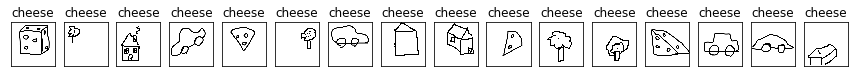

In [5]:
# Default optimizer, learning rate and number of epochs used in Xfer to train neural network
DEFAULT_OPTIMIZER = 'sgd'
DEFAULT_OPTIMIZER_PARAMS = {'learning_rate': 0.001}  
DEFAULT_NUM_EPOCHS = 5

TARGET_CLASS_COUNT = 4  # 4 classes of sketch images are used for this demo (car, cheese, house and tree)
CONTEXT_FUNCTION = mx.cpu # 'mx.gpu' or 'mx.cpu' (MXNet context function to train neural network)

# Layers to freeze or randomly initialize during neural network training. 
# For this demo, we freeze the first 8 out of 16 convolutional layers transferred from 'vgg19' model. 
FIXED_LAYERS = ['conv1_1','conv1_2','conv2_1','conv2_2','conv3_1','conv3_2','conv3_3','conv3_4']
RANDOM_LAYERS = []

# Method to repurpose neural network with given hyperparameters
def train_and_predict(source_model, train_data_iterator, test_data_iterator, optimizer, optimizer_params):
    set_random_seeds()
    repurposer = xfer.NeuralNetworkRandomFreezeRepurposer(source_model, 
                                                          optimizer=optimizer, 
                                                          optimizer_params=optimizer_params,
                                                          target_class_count=TARGET_CLASS_COUNT, 
                                                          fixed_layers=FIXED_LAYERS, 
                                                          random_layers=RANDOM_LAYERS,
                                                          context_function=CONTEXT_FUNCTION,
                                                          num_epochs=DEFAULT_NUM_EPOCHS)
    repurposer.repurpose(train_data_iterator)
    predictions = repurposer.predict_label(test_data_iterator)
    return predictions

# Train neural network with default hyperparameters
predictions = train_and_predict(source_model, train_validation_iterator, test_iterator, 
                                   DEFAULT_OPTIMIZER, DEFAULT_OPTIMIZER_PARAMS)
precision_default = np.mean(predictions == test_labels)
print('Trained neural network with default hyperparameters. Precision: {}'.format(precision_default))

# Display test images and predictions
test_images = get_images(test_iterator)
show_predictions(predictions, test_images, id2label)

Note that the quality of the results may vary due to randomness e.g. in the initialization of the neural network weights. However, the idea is that, since the precision varies with different choices of the learning rate and in certain cases the default learning rate might not be the best. We therefore wish to find a good learning rate automatically rather than with trial-and-error. HPO helps us achieve this, as demonstrated below.

### D) Repurpose with HPO: Optimizing learning rate

#### i) Declare the hyperparameter to optimize and its domain

In [6]:
# Learning rate is the hyperparameter we will optimize here
# We allow GPyOpt to operate in a normalized domain [0,1] and map the value to a desired log scale inside our objective function
# This helps GPyOpt to learn a smooth underlying function in fewer iterations
gpyopt_domain = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0,1)}]

# Method to map a value given by GPyOpt in [0, 1] to a desired range of learning rate
def map_learning_rate(source_value):
    if(source_value < 0 or source_value > 1):
        raise ValueError('source_value must be in the range [0,1]')
    
    # We explore learning rate in the range [1e-6 , 1e-1]. You can choose a different range to explore
    # Log scale is used here because it is an intuitive way to explore learning rates
    # For example, if 1e-2 doesn't work, we tend to explore 1e-3 or 1e-1 which is a jump in log scale
    log_learning_rate_start = -6  # 1e-6 in linear scale
    log_learning_rate_end = -1  # 1e-1 in linear scale
    
    log_span = abs(log_learning_rate_end - log_learning_rate_start)
    log_mapped_value = log_learning_rate_start + (source_value * log_span)
    mapped_value = 10 ** log_mapped_value  # Convert from log scale to linear scale
    return mapped_value

#### ii) Define an objective function to optimize the hyperparameter

In [7]:
def get_hyperparameters_from_config(config):
    """ 
    Extract hyperparameters from input configuration provided by GPyOpt.
    Refer the caller 'hpo_objective_function' for more details.
    """
    learning_rate = map_learning_rate(config[0]) # Map learning_rate value given by GPyOpt to the desire range
    optimizer = DEFAULT_OPTIMIZER  # Using default optimizer here i.e. 'sgd'
    return optimizer, learning_rate

def hpo_objective_function(config_matrix):
    """ 
    Objective function to optimize the hyperparameters for
    This method is called by GPyOpt internally to get outputs of objective function for different input configurations
    
    We train a neural network with given hyperparameters and return (1-precision) on validation data as the output
    You can choose to optimize for a different measure and create the objective function accordingly
    Here, we consider one hyperparameter (learning_rate) to optimize precision
    
    Note: config_matrix has m rows and n columns
    m denotes the number of experiments to run i.e. each row would contain input configuration to run one experiment
    n denotes the number of hyperparameters (e.g. 2 columns for learning_rate and batch_size)
    """
    # Output of objective function for each input configuration
    function_output = np.zeros((config_matrix.shape[0], 1))
    
    # For each input configuration, train a nerual network and calculate accuracy on validation data
    for idx, config in enumerate(config_matrix):
        optimizer, learning_rate = get_hyperparameters_from_config(config)

        # Train neural network with the mapped learning rate and get predictions on validation data
        predictions = train_and_predict(source_model=source_model, 
                                           train_data_iterator=train_iterator, 
                                           test_data_iterator=validation_iterator,
                                           optimizer = optimizer,
                                           optimizer_params = {'learning_rate': learning_rate})
 
        # Calculate precision on validation set and update function_output with (1-precision)
        precision = np.mean(predictions == validation_labels)
        function_output[idx][0] = (1.0 - precision)  # (1-precision) to keep a minimization objective
        print('learning_rate: {}. optimizer: {}. precision: {}'.format(learning_rate, optimizer, precision))
        gc.collect()
    
    return function_output

#### iii) Initialize a Bayesian optimizer using GPyOpt

In [8]:
set_random_seeds()
NUM_INITIAL_POINTS = 2
hyperparameter_optimizer = GPyOpt.methods.BayesianOptimization(f=hpo_objective_function, 
                                                               domain=gpyopt_domain, 
                                                               initial_design_numdata=NUM_INITIAL_POINTS)

learning_rate: 9.069790423538591e-06. optimizer: sgd. precision: 0.75
learning_rate: 0.0012898638021921914. optimizer: sgd. precision: 0.25


#### iv) Run more iterations to identify a better learning rate for our objective function

In [9]:
set_random_seeds()
NUM_ITERATIONS_TO_RUN = 5
hyperparameter_optimizer.run_optimization(max_iter = NUM_ITERATIONS_TO_RUN)

 /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/paramz/parameterized.py:266: DeprecationWarning:Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
 /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/paramz/parameterized.py:267: DeprecationWarning:Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
 /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/paramz/core/parameter_core.py:290: DeprecationWarning:Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
 /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/paramz/core/parameter_core.py:291: DeprecationWarning:Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.


learning_rate: 9.013709494113845e-06. optimizer: sgd. precision: 0.75
learning_rate: 1e-06. optimizer: sgd. precision: 0.3333333333333333
learning_rate: 4.282331345690733e-05. optimizer: sgd. precision: 0.9166666666666666
learning_rate: 8.400869431085012e-05. optimizer: sgd. precision: 0.9166666666666666
learning_rate: 0.1. optimizer: sgd. precision: 0.25


#### v) Results

#### Learning rates evaluated
The plot below shows the different learning rates explored by GPyOpt in the normalized domain [0, 1].

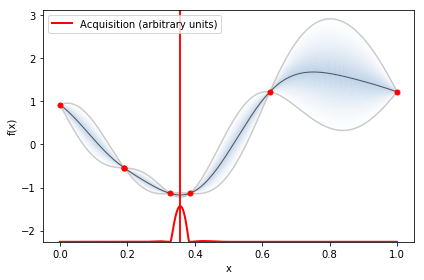

In [10]:
hyperparameter_optimizer.plot_acquisition()

#### Optimized learning rate

In [11]:
# Take hyperparameters that minimized the objective function output
x_best = hyperparameter_optimizer.X[np.argmin(hyperparameter_optimizer.Y)]
optimized_learning_rate = map_learning_rate(x_best[0])
precision = 1.0 - min(hyperparameter_optimizer.Y)[0]  # Objective was to minimize 1-precision 
print('Optimized learning rate: {}. Precision on validation data: {}'.format(optimized_learning_rate, precision))

Optimized learning rate: 4.282331345690733e-05. Precision on validation data: 0.9166666666666666


Note that the optimized learning rate found is from the iterations run so far. Based on time available, one can run more iterations which may help in obtaining a more optimized learning rate.

#### Precision on test data with optimal learning rate

Optimized learning rate: 4.282331345690733e-05. Precision on test data: 0.9375


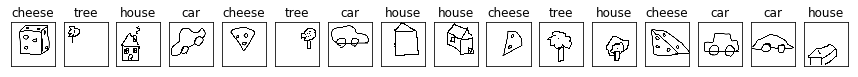

In [12]:
# Train neural network with optimal learning rate and get predictions on test data
# Along with training data, validation data is also used to train the final model
predictions = train_and_predict(source_model=source_model, 
                                   train_data_iterator=train_validation_iterator,  # train on (train + validation) set
                                   test_data_iterator=test_iterator,  # predict on test data
                                   optimizer = DEFAULT_OPTIMIZER,
                                   optimizer_params = {'learning_rate': optimized_learning_rate})
precision_optimized = np.mean(predictions == test_labels)
print('Optimized learning rate: {}. Precision on test data: {}'.format(optimized_learning_rate, precision_optimized))
show_predictions(predictions, test_images, id2label)

### E) Repurpose with HPO: Optimizing multiple hyperparameters
The following section can be used for reference when someone wants to optimize multiple hyperparameters to repurpose models using Xfer. Here, the hyperparameters chosen are: 
1. Optimizer for neural network (sgd or adam). 
2. Learning rate.

Note that running more iterations could be useful here because there are more combination of values to explore.

learning_rate: 0.001149633666386761. optimizer: adam. precision: 0.25
learning_rate: 0.007191170640325595. optimizer: adam. precision: 0.08333333333333333
learning_rate: 0.02010707310312527. optimizer: sgd. precision: 0.25
learning_rate: 5.6648032172494754e-06. optimizer: adam. precision: 0.8333333333333334
learning_rate: 9.830911695227397e-06. optimizer: sgd. precision: 0.75


 /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/paramz/parameterized.py:266: DeprecationWarning:Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
 /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/paramz/parameterized.py:267: DeprecationWarning:Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
 /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/paramz/core/parameter_core.py:290: DeprecationWarning:Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
 /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/paramz/core/parameter_core.py:291: DeprecationWarning:Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.


learning_rate: 1e-06. optimizer: adam. precision: 0.6666666666666666
learning_rate: 9.593814398728716e-06. optimizer: adam. precision: 0.8333333333333334
learning_rate: 7.219980026534939e-06. optimizer: adam. precision: 0.8333333333333334
learning_rate: 6.463532565135723e-06. optimizer: adam. precision: 0.8333333333333334
learning_rate: 8.21054580162481e-06. optimizer: adam. precision: 0.8333333333333334
Optimized learning rate: 5.6648032172494754e-06. Optimizer: adam. Precision on validation data: 0.8333333333333334
Optimized learning rate: 5.6648032172494754e-06. Optimizer: adam. Precision on test data: 0.875


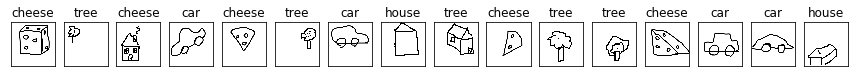

In [13]:
# Choose the hyperparameters and specify the domain
optimizer_id_to_name = {1: 'sgd', 2:'adam'}
domain_with_2_hyperparams = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0,1)},
                              {'name': 'optimizer', 'type': 'discrete', 'domain': (1,2)}]

# Override this method to extract the optimizer in addition to learning_rate from GPyOpt config
def get_hyperparameters_from_config(config):
    """ 
    Extract hyperparameters from input configuration provided by GPyOpt.
    Refer the caller 'hpo_objective_function' for more details.
    """
    learning_rate = map_learning_rate(config[0]) # Map learning_rate value given by GPyOpt to the desire range
    optimizer = optimizer_id_to_name[config[1]]  # Using optimizer given by GPyOpt
    return optimizer, learning_rate

# Initialize GPyOpt with new domain and run optimization
set_random_seeds()
hyperparameter_optimizer2 = GPyOpt.methods.BayesianOptimization(f=hpo_objective_function,
                                                                domain=domain_with_2_hyperparams, 
                                                                initial_design_numdata=5)
hyperparameter_optimizer2.run_optimization(max_iter=5)

# Take hyperparameters that minimized the objective function output
x_best2 = hyperparameter_optimizer2.X[np.argmin(hyperparameter_optimizer2.Y)]
optimized_learning_rate2 = map_learning_rate(x_best2[0])
precision2 = 1.0 - min(hyperparameter_optimizer2.Y)[0]  # Objective was to minimize 1-precision 
print('Optimized learning rate: {}. Optimizer: {}. Precision on validation data: {}'
      .format(optimized_learning_rate2, optimizer_id_to_name[x_best2[1]], precision2))

# Train neural network with optimal (learning rate, optimizer) and get predictions on test data
# Along with training data, validation data is also used to train the final model
predictions2 = train_and_predict(source_model=source_model, 
                                   train_data_iterator=train_validation_iterator,  # train on (train + validation) set
                                   test_data_iterator=test_iterator,  # predict on test data
                                   optimizer = DEFAULT_OPTIMIZER,
                                   optimizer_params = {'learning_rate': optimized_learning_rate2})
precision_optimized2 = np.mean(predictions2 == test_labels)
print('Optimized learning rate: {}. Optimizer: {}. Precision on test data: {}'
      .format(optimized_learning_rate2, optimizer_id_to_name[x_best2[1]], precision_optimized2))
show_predictions(predictions2, test_images, id2label)